# Introduction

This dataset contains information about adults' income and their different status like education, gender and martial status. 

First, we will did a deep-dive analysis into each field of the data, finding useful facts and provide some insights.

Next, we will build some machine learning models which tries to conduct a binary prediction if a person will make more than $50K a year.

The structure of this analysis is as follows:

1. Data loading and inspection

2. Exploratory Data Analysis

3. Model Training


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import collections
import functions
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pipe import FeatureExtractor, CategoricalEncoding
from sklearn.pipeline import make_pipeline, make_union 
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, make_scorer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import bar

In [2]:
train = pd.read_csv('au_train.csv')
test = pd.read_csv('au_test.csv')
train['fnlwgt'] = np.log1p(train['fnlwgt'])
test['fnlwgt'] = np.log1p(test['fnlwgt'])
train['age'] = np.log1p(train['age'])
test['age'] = np.log1p(test['age'])
train['capital-gain_missing'] = pd.Series([1 if i == 99999 else 0 for i in train['capital-gain']])
test['capital-gain_missing'] = pd.Series([1 if i == 99999 else 0 for i in test['capital-gain']])

# Model Training

## a. Baseline Model

**Prepare data for linear model**

In [3]:
tr = train.copy()
te = test.copy()
train = train.drop('education', axis=1)
test = test.drop('education', axis=1)
encoded_data,en = functions.number_encode_features(train)
train_onehot = pd.get_dummies(train)
test_onehot = pd.get_dummies(test)

test_onehot["class"] = test_onehot["class_ >50K."]
del test_onehot["class_ <=50K."]
del test_onehot["class_ >50K."]

train_onehot["class"] = train_onehot["class_ >50K"]
del train_onehot["class_ <=50K"]
del train_onehot["class_ >50K"]

a = list(train_onehot.columns)
a.remove('class')


x_train, x_test, y_train, y_test = train_test_split(train_onehot[a], 
                                                    train_onehot["class"], test_size=0.33, random_state=109)

**Logistic Regression**

The auc score and accuracy show that the model is doing good, however, the result from confusion matrix tells a different story.

While the logistic classifier doing good in predicting *<=50K*, the false positive rate is very high.

It is a possible result due to imbalaced dataset since there are 76% observations are *<=50K* in *class*.

**So, though the auc score and accuracy is good, we still think this model is a bad classifier.**

In order to improve the model, let's try some rebalance technique.

accuracy:  0.85
f1 score:  0.66
auc score:  0.9


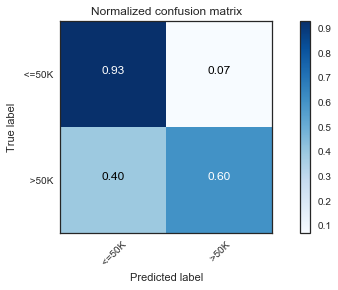

In [4]:
log = LogisticRegression()
log.fit(x_train, y_train)
y_pred_log = log.predict(x_test)
y_pred_prob_log = log.predict_proba(x_test)
y_pred_prob_log = np.array([i[1] for i in y_pred_prob_log])
cm_log = confusion_matrix(y_test,y_pred_log)
print('accuracy: ', round(accuracy_score(y_test,y_pred_log),2))
print('f1 score: ', round(f1_score(y_test,y_pred_log),2))
print('auc score: ',round(roc_auc_score(y_test,y_pred_prob_log),2))
functions.plot_confusion_matrix(cm_log, classes=en['class'].classes_,
                      title='Normalized confusion matrix')
plt.show()

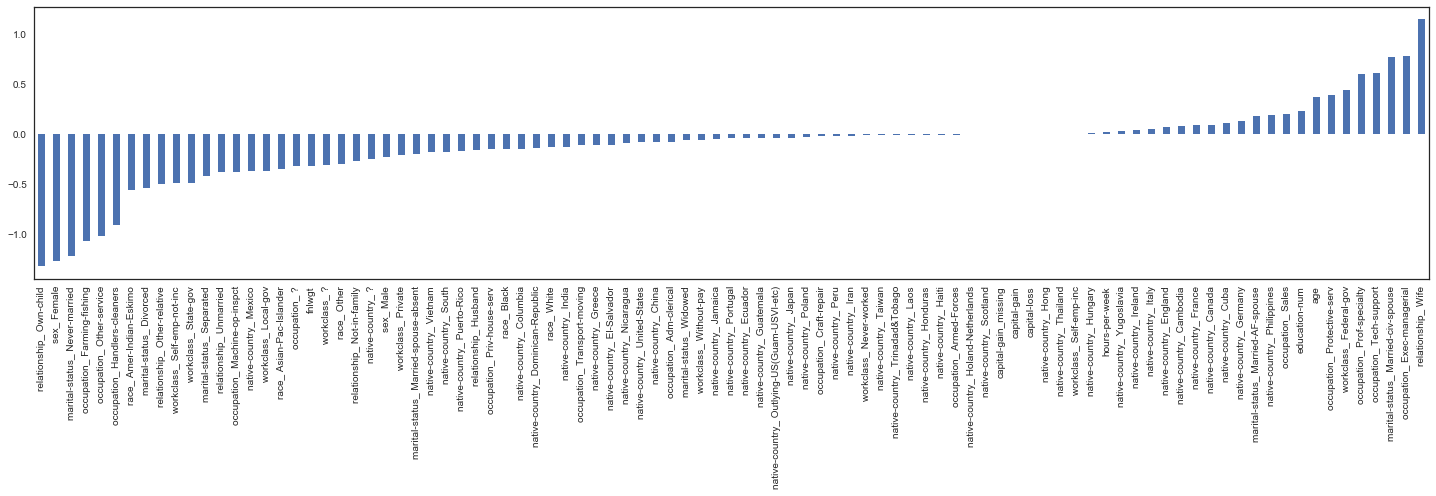

In [5]:
coefs = pd.Series(log.coef_[0], index=x_train.columns)
coefs = coefs.sort_values()
plt.subplots(figsize=(25,5))
coefs.plot(kind="bar")
plt.show()

## b. Resample Technique

**1. OverSampling**

As we can see from the result, the accuracy and f1 score are lower than the original one and the auc score stay the same.

However, there is a big improvement in confusion matrix. Both specificity and sensitivity are higher right now.

So, if we want to focus more on specificity and sensitivity, oversampling the dataset is a good choice.

accuracy:  0.79
f1 score:  0.65
auc score:  0.89


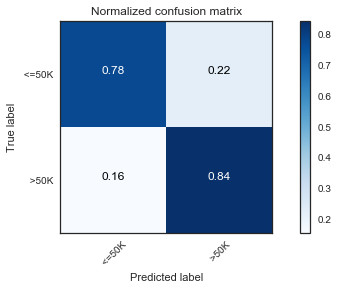

In [6]:
over_s = RandomOverSampler()
x_train_os, y_train_os = over_s.fit_sample(x_train, y_train)
log_os = LogisticRegression()
log_os.fit(x_train_os, y_train_os)
y_pred_log_os = log_os.predict(x_test)
y_pred_prob_log_os = log_os.predict_proba(x_test)
y_pred_prob_log_os = np.array([i[1] for i in y_pred_prob_log_os])
cm_log_os = confusion_matrix(y_test,y_pred_log_os)
print('accuracy: ', round(accuracy_score(y_test,y_pred_log_os),2))
print('f1 score: ', round(f1_score(y_test,y_pred_log_os),2))
print('auc score: ',round(roc_auc_score(y_test,y_pred_prob_log_os),2))
functions.plot_confusion_matrix(cm_log_os, classes=en['class'].classes_,
                      title='Normalized confusion matrix')
plt.show()

**2. UnderSampling**

Compared to Oversampling, undersampling is a little bit worse. 

All of three metrics have slightly decreases. The reason maybe undersampling throw away too much data so the model can't not learning as much as original, however, if we want to focus more on specificity and sensitivity, though the size shrinks to less than half of the original data size, the result from confusion matrix is better than original one.

accuracy:  0.79
f1 score:  0.66
auc score:  0.9


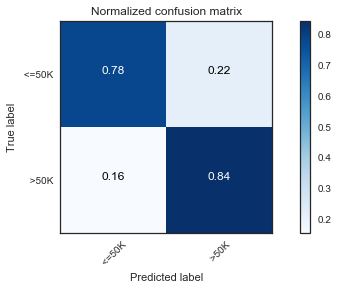

In [7]:
under_s = RandomUnderSampler()
x_train_us, y_train_us = under_s.fit_sample(x_train, y_train)
log_us = LogisticRegression()
log_us.fit(x_train_us, y_train_us)
y_pred_log_us = log_us.predict(x_test)
y_pred_prob_log_us = log_us.predict_proba(x_test)
y_pred_prob_log_us = np.array([i[1] for i in y_pred_prob_log_us])
cm_log_us = confusion_matrix(y_test,y_pred_log_us)
print('accuracy: ', round(accuracy_score(y_test,y_pred_log_us),2))
print('f1 score: ', round(f1_score(y_test,y_pred_log_us),2))
print('auc score: ',round(roc_auc_score(y_test,y_pred_prob_log_us),2))
functions.plot_confusion_matrix(cm_log_us, classes=en['class'].classes_,
                      title='Normalized confusion matrix')
plt.show()

**3.SMOTE+ENN**

From the result we can see that using Synthetic Minority Over-sampling Technique, the f1 score is much better than using the above dataset.

accuracy:  0.83
f1 score:  0.84
auc score:  0.91


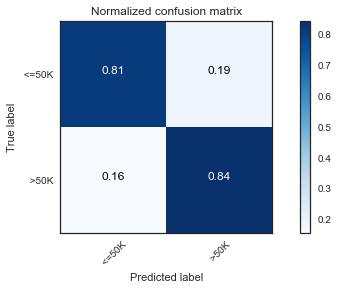

In [8]:
sm = SMOTEENN()
a = list(train.columns)
a.remove('class')
encoded_train,en = functions.number_encode_features(train)
encoded_test,en_ = functions.number_encode_features(test)
trainx_sm, trainy_sm = sm.fit_sample(encoded_train[a], encoded_train['class'])
testx_sm, testy_sm = sm.fit_sample(encoded_test[a], encoded_test['class'])

trainx_sm = pd.DataFrame(trainx_sm,columns=a)
train_onehot_sm = pd.get_dummies(trainx_sm)

testx_sm = pd.DataFrame(testx_sm,columns=a)
test_onehot_sm = pd.get_dummies(testx_sm)

x_train_sm, x_test_sm, y_train_sm, y_test_sm = train_test_split(train_onehot_sm, 
                                                    trainy_sm, test_size=0.33, random_state=109)
log_sm = LogisticRegression()
log_sm.fit(x_train_sm, y_train_sm)
y_pred_log_sm = log_sm.predict(x_test_sm)
y_pred_prob_log_sm = log_sm.predict_proba(x_test_sm)
y_pred_prob_log_sm = np.array([i[1] for i in y_pred_prob_log_sm])
cm_log_sm = confusion_matrix(y_test_sm,y_pred_log_sm)
print('accuracy: ', round(accuracy_score(y_test_sm,y_pred_log_sm),2))
print('f1 score: ', round(f1_score(y_test_sm,y_pred_log_sm),2))
print('auc score: ',round(roc_auc_score(y_test_sm,y_pred_prob_log_sm),2))
functions.plot_confusion_matrix(cm_log_sm, classes=en['class'].classes_,
                      title='Normalized confusion matrix')
plt.show()

## c. Other Models

**Random Forest + (SMOTE+ENN)**

Since tree-based methods perform bad on one-hot encoding, we will use numerical encoding to build new dataset.

Using crossvalidation to tune the parameter, we can get much higher results in all three metrics.

In [9]:
x_train_sm_t, x_test_sm_t, y_train_sm_t, y_test_sm_t = train_test_split(trainx_sm, trainy_sm, test_size=0.33, random_state=109)

accuracy:  0.97
f1 score:  0.97
auc score:  1.0


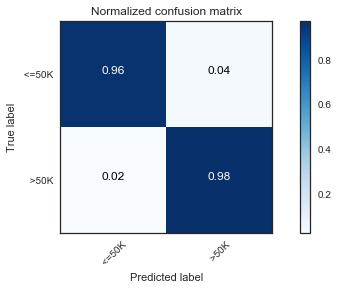

In [11]:
rkf = RepeatedKFold(n_splits=10, n_repeats=2)
parameters = {'max_depth':[25,50],'n_estimators':[10,50,100]}
f1 = make_scorer(f1_score)
rf = RandomForestClassifier(random_state=0)
rf_cv = GridSearchCV(rf, parameters,cv=rkf,pre_dispatch=4, return_train_score = True,scoring=f1)
rf_cv.fit(x_train_sm_t, y_train_sm_t)

y_pred_rf_sm = rf_cv.predict(x_test_sm_t)
y_pred_prob_rf_sm = rf_cv.predict_proba(x_test_sm_t)
y_pred_prob_rf_sm = np.array([i[1] for i in y_pred_prob_rf_sm])
cm_log_rf_sm = confusion_matrix(y_test_sm_t,y_pred_rf_sm)
print('accuracy: ', round(accuracy_score(y_test_sm_t,y_pred_rf_sm),2))
print('f1 score: ', round(f1_score(y_test_sm_t,y_pred_rf_sm),2))
print('auc score: ',round(roc_auc_score(y_test_sm_t,y_pred_prob_rf_sm),2))
functions.plot_confusion_matrix(cm_log_rf_sm, classes=en['class'].classes_,
                      title='Normalized confusion matrix')
plt.show()

**SVM + (SMOTE+ENN)**

accuracy:  0.95
f1 score:  0.96


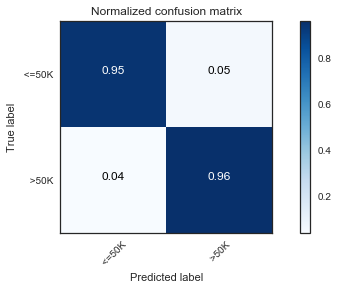

In [11]:
svm_cv = svm.SVC()
svm_cv.fit(x_train_sm, y_train_sm)  
y_pred_rf_sm = svm_cv.predict(x_test_sm)
cm_log_rf_sm = confusion_matrix(y_test_sm,y_pred_rf_sm)
print('accuracy: ', round(accuracy_score(y_test_sm,y_pred_rf_sm),2))
print('f1 score: ', round(f1_score(y_test_sm,y_pred_rf_sm),2))
functions.plot_confusion_matrix(cm_log_rf_sm, classes=en['class'].classes_,
                      title='Normalized confusion matrix')
plt.show()

## d. Feature Importance

We use random forest to check important features, from the plot below, we can see that **relationship** is the most important feature, whereas the created feature **capital-gain_missing** is least important. **race** and **native-country** are less important features in the dataset.

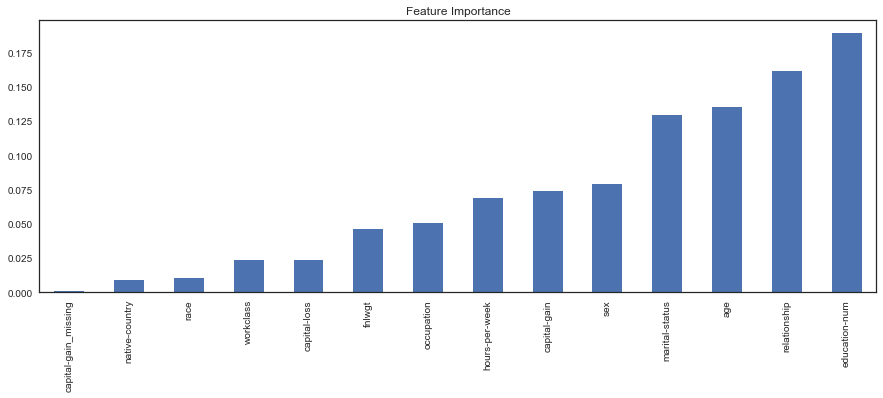

In [12]:
coefs = pd.Series(rf_cv.best_estimator_.feature_importances_, index=a)
coefs = coefs.sort_values()
plt.subplots(figsize=(15,5))
plt.title('Feature Importance')
coefs.plot(kind="bar")
plt.show()

## e. Feature Interactions

Generate interactions between categorical features to see if the performance of logistic regression is improved

As we can see below, there is huge improvement in all three metrics, since the tree-based model consider feature interaction during split, we don't need to manually create interaction, but as long as we increase the features for linear model, the performance will improve. 

In [13]:
cate_list = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
functions.generate_interaction(tr, cate_list)
functions.generate_interaction(te,cate_list)

[ ==================== ] 100.00%

accuracy:  0.9
f1 score:  0.9
auc score:  0.96


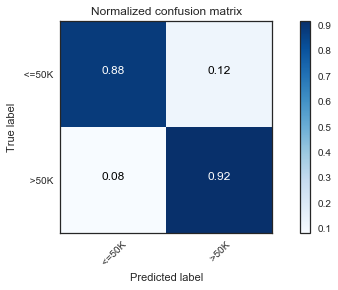

In [14]:
sm = SMOTEENN()
a = list(tr.columns)
a.remove('class')
a.remove('education')
encoded_train,en = functions.number_encode_features(tr)
encoded_test,en_ = functions.number_encode_features(te)
trainx_sm, trainy_sm = sm.fit_sample(encoded_train[a], encoded_train['class'])
testx_sm, testy_sm = sm.fit_sample(encoded_test[a], encoded_test['class'])

trainx_sm = pd.DataFrame(trainx_sm,columns=a)
train_onehot_sm = pd.get_dummies(trainx_sm)

testx_sm = pd.DataFrame(testx_sm,columns=a)
test_onehot_sm = pd.get_dummies(testx_sm)

x_train_sm, x_test_sm, y_train_sm, y_test_sm = train_test_split(train_onehot_sm, 
                                                    trainy_sm, test_size=0.33, random_state=109)
log_sm = LogisticRegression()
log_sm.fit(x_train_sm, y_train_sm)
y_pred_log_sm = log_sm.predict(x_test_sm)
y_pred_prob_log_sm = log_sm.predict_proba(x_test_sm)
y_pred_prob_log_sm = np.array([i[1] for i in y_pred_prob_log_sm])
cm_log_sm = confusion_matrix(y_test_sm,y_pred_log_sm)
print('accuracy: ', round(accuracy_score(y_test_sm,y_pred_log_sm),2))
print('f1 score: ', round(f1_score(y_test_sm,y_pred_log_sm),2))
print('auc score: ',round(roc_auc_score(y_test_sm,y_pred_prob_log_sm),2))
functions.plot_confusion_matrix(cm_log_sm, classes=en['class'].classes_,
                      title='Normalized confusion matrix')
plt.show()

## f. Predict

At last, we should use one or ensemble model to predict the test data.

Since random forest has very good result, we only use it to do prediction.

accuracy:  0.92
f1 score:  0.92
auc score:  0.97


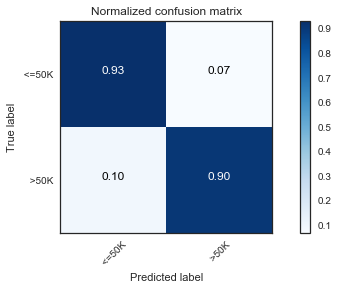

In [15]:
rkf = RepeatedKFold(n_splits=10, n_repeats=2)
parameters = {'max_depth':[5,10,25,50,75]}
f1 = make_scorer(f1_score)
rf = RandomForestClassifier(random_state=0)
rf_cv = GridSearchCV(rf, parameters,cv=rkf,pre_dispatch=4, return_train_score = True,scoring=f1)
rf_cv.fit(trainx_sm, trainy_sm)

y_pred_rf_sm = rf_cv.predict(testx_sm)
y_pred_prob_rf_sm = rf_cv.predict_proba(testx_sm)
y_pred_prob_rf_sm = np.array([i[1] for i in y_pred_prob_rf_sm])
cm_log_rf_sm = confusion_matrix(testy_sm,y_pred_rf_sm)
print('accuracy: ', round(accuracy_score(testy_sm,y_pred_rf_sm),2))
print('f1 score: ', round(f1_score(testy_sm,y_pred_rf_sm),2))
print('auc score: ',round(roc_auc_score(testy_sm,y_pred_prob_rf_sm),2))
functions.plot_confusion_matrix(cm_log_rf_sm, classes=en['class'].classes_,
                      title='Normalized confusion matrix')
plt.show()
